In [1]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# LABEL IS G3, G1 AND G2 ARE INCLUDED FEATURES
# First two returns are just the full dataset X and y
# Next two are the edited dataset without highly correlated inputs
# Last two are an edited dataset with only the six highest correlating inputs
def load_math_G3():
    full_dataset = pd.read_csv("Math-Students.csv", sep=",")

    # Create dataset with all data for testing
    fData_X = full_dataset.drop("G3", axis=1)
    fData_y = full_dataset["G3"]
    fData_X = pd.get_dummies(fData_X, drop_first=True)  # one-hot encode categorical features

    # Split X and y for complex dataset (all non-correlated features)
    correlation_drop = ['Dalc', 'Walc', 'Fedu']
    complex_dataset = full_dataset.drop(columns=correlation_drop)
    cData_X = complex_dataset.drop("G3", axis=1)
    cData_y = complex_dataset["G3"]
    cData_X = pd.get_dummies(cData_X, drop_first=True)  # one-hot encode categorical features

    # Split X and y for simple dataset (only features with highest G_avg correlation)
    best_features = ['failures', 'Medu', 'goout', 'age', 'studytime', 'traveltime']
    simple_dataset = complex_dataset[best_features + ['G3']]
    sData_X = simple_dataset.drop("G3", axis=1)
    sData_y = simple_dataset["G3"]
    sData_X = pd.get_dummies(sData_X, drop_first=True)  # one-hot encode categorical features

    return fData_X, fData_y, cData_X, cData_y, sData_X, sData_y

# LABEL IS G_avg, G1 AND G2 ARE DROPPED
# First two returns are just the full dataset X and y
# Next two are the edited dataset without highly correlated inputs
# Last two are an edited dataset with only the six highest correlating inputs
def load_math_G_avg():
    full_dataset = pd.read_csv("Math-Students.csv", sep=",")

    # Change output label to average of grades
    grades = ['G1', 'G2', 'G3']
    full_dataset['G_avg'] = full_dataset[grades].mean(axis=1)
    full_dataset = full_dataset.drop(columns=grades)

    # Create dataset with all data for testing
    fData_X = full_dataset.drop("G_avg", axis=1)
    fData_y = full_dataset["G_avg"]
    fData_X = pd.get_dummies(fData_X, drop_first=True)  # one-hot encode categorical features

    # Split X and y for complex dataset (all non-correlated features)
    correlation_drop = ['Dalc', 'Walc', 'Fedu']
    complex_dataset = full_dataset.drop(columns=correlation_drop)
    cData_X = complex_dataset.drop("G_avg", axis=1)
    cData_y = complex_dataset["G_avg"]
    cData_X = pd.get_dummies(cData_X, drop_first=True)  # one-hot encode categorical features

    # Split X and y for simple dataset (only features with highest G_avg correlation)
    best_features = ['failures', 'Medu', 'goout', 'age', 'studytime', 'traveltime']
    simple_dataset = complex_dataset[best_features + ['G_avg']]
    sData_X = simple_dataset.drop("G_avg", axis=1)
    sData_y = simple_dataset["G_avg"]
    sData_X = pd.get_dummies(sData_X, drop_first=True)  # one-hot encode categorical features

    return fData_X, fData_y, cData_X, cData_y, sData_X, sData_y

def polynomial_regression(degree, X, y, folds, test_size=0.2):
    kf = KFold(folds)

    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(X)

    total_errors = []
    models = []
    current_fold = 0
    for train_index, test_index in kf.split(X_poly):
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        average_prediction = np.mean(y_pred)
        variance = np.mean((average_prediction - y_pred)**2)
        bias2 = np.mean((average_prediction - y_test)**2)
        total_error = variance + bias2

        # Append results to lists
        total_errors.append(total_error)
        models.append(model)

        current_fold += 1

    # choose best model
    min_error_index = np.argmin(total_errors)
    best_model = models[min_error_index]

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size, random_state=42)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    plt.scatter(y_test, y_pred, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('Predicted vs True Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, best_model

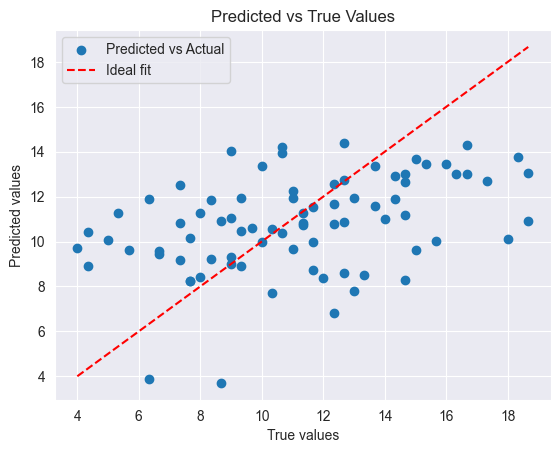

Degree 1 MSE: 11.521470231705816 R2: 0.11613041370660648


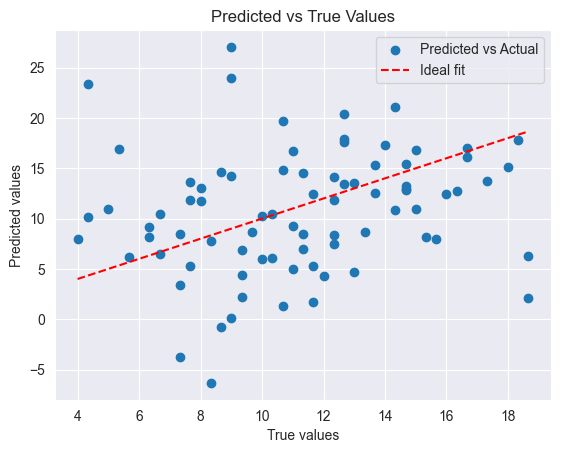

Degree 2 MSE: 42.30311951653633 R2: -2.245283804414698


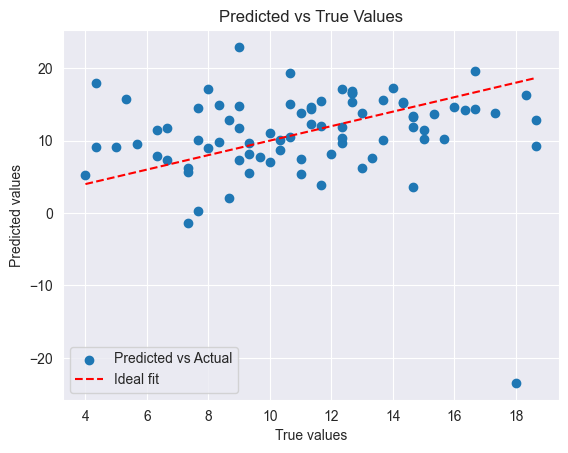

Degree 3 MSE: 44.84518480450784 R2: -2.440298342422797


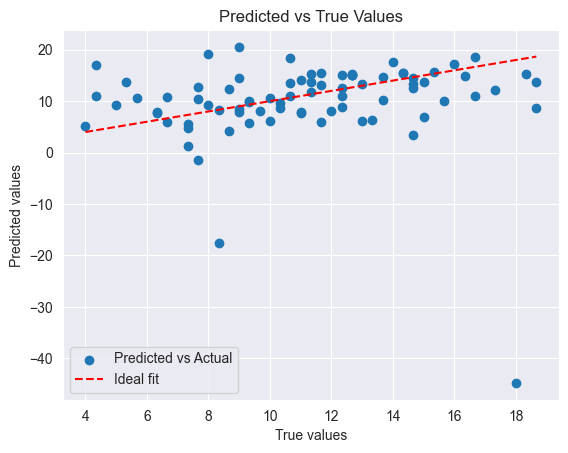

Degree 4 MSE: 78.3204733576379 R2: -5.008355096419757


In [3]:
# G_avg prediction removing correlated inputs
_, _, X, y, _, _ = load_math_G_avg()
folds = 4
degrees = range(1, 5)
for degree in degrees:
    mse, r2, model = polynomial_regression(degree, X, y, folds)
    print("Degree", degree, "MSE:", mse, "R2:", r2)

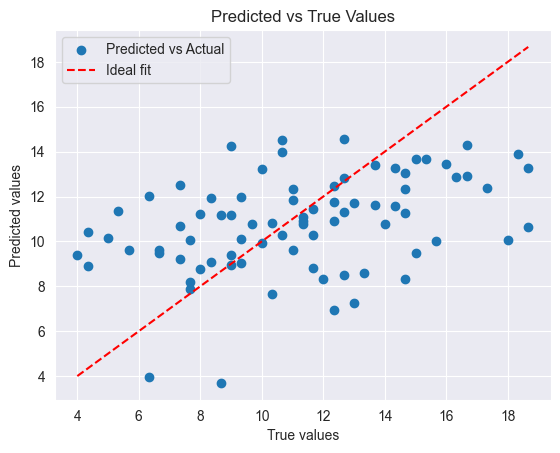

Degree 1 MSE: 11.724735560995425 R2: 0.10053691401482301


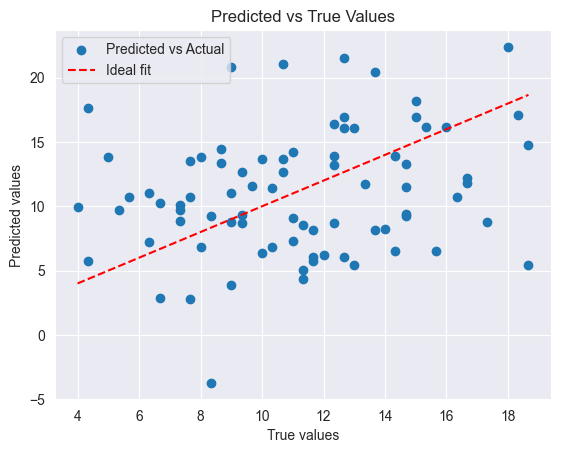

Degree 2 MSE: 28.05215643238023 R2: -1.1520211745454052


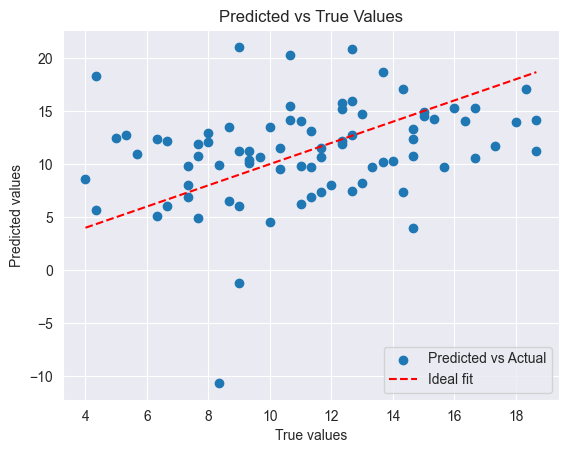

Degree 3 MSE: 25.588707312919183 R2: -0.96303767588731


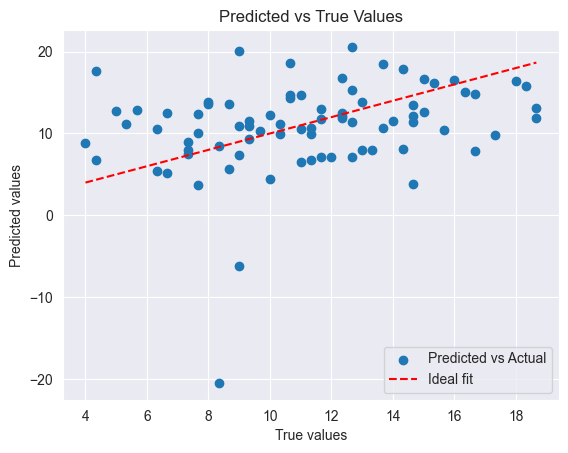

Degree 4 MSE: 33.05514603824635 R2: -1.535825521059985


In [4]:
# Predict G_avg using all of the other features
X, y, _, _, _, _ = load_math_G_avg()
folds = 4
degrees = range(1, 5)
for degree in degrees:
    mse, r2, model = polynomial_regression(degree, X, y, folds)
    print("Degree", degree, "MSE:", mse, "R2:", r2)

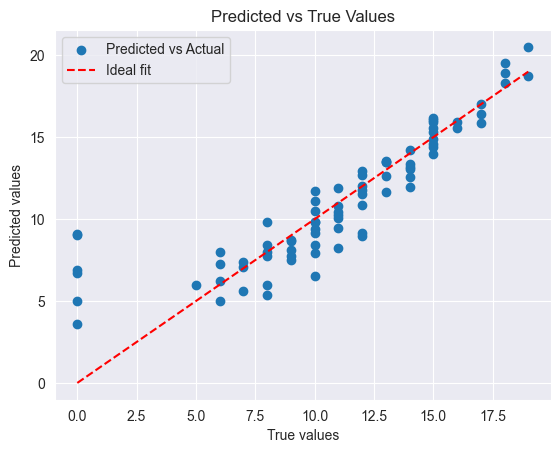

Degree 1 MSE: 5.048478194691486 R2: 0.7556233373972279


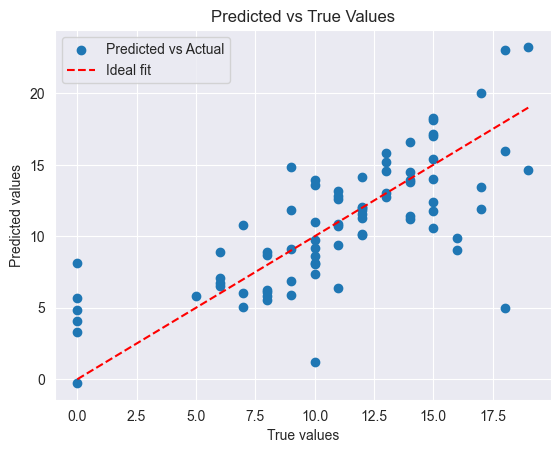

Degree 2 MSE: 11.246174210201428 R2: 0.45561763078857065


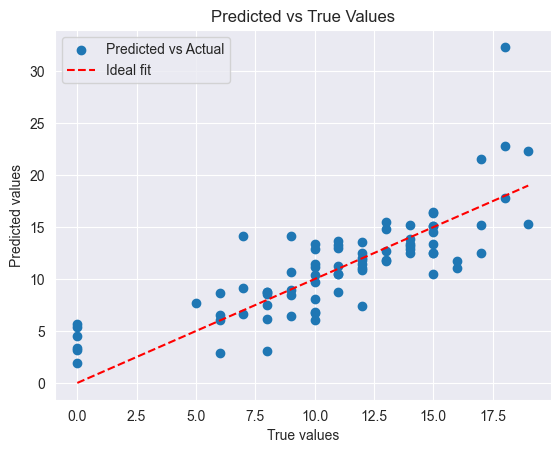

Degree 3 MSE: 9.555471288250693 R2: 0.5374578055076622


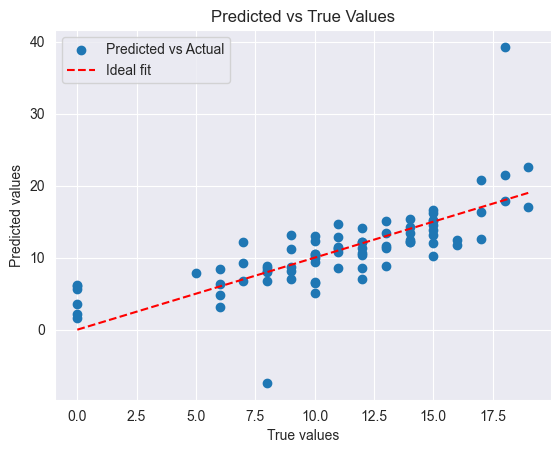

Degree 4 MSE: 15.079301096122355 R2: 0.2700712701646327


In [5]:
# Predict G3 using all of the other features
X, y, _, _, _, _ = load_math_G3()
folds = 4
degrees = range(1, 5)
for degree in degrees:
    mse, r2, model = polynomial_regression(degree, X, y, folds)
    print("Degree", degree, "MSE:", mse, "R2:", r2)

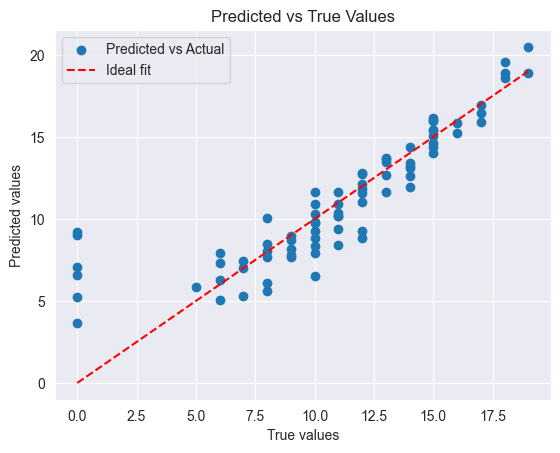

Degree 1 MSE: 5.118849476365915 R2: 0.7522169447585989


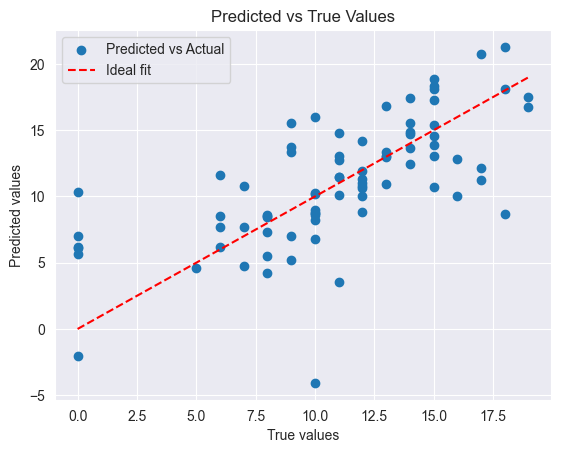

Degree 2 MSE: 14.163839566244599 R2: 0.3143851058959617


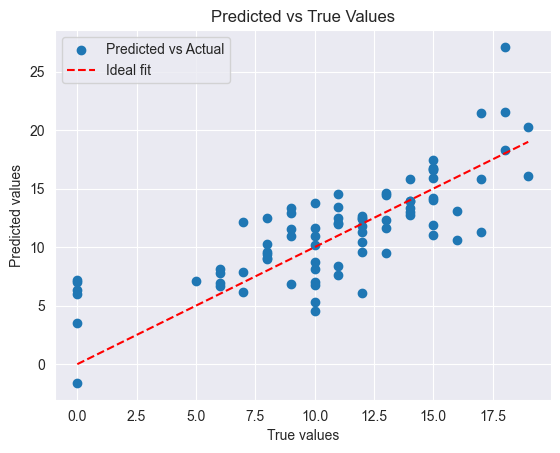

Degree 3 MSE: 9.482244879092743 R2: 0.5410024034625908


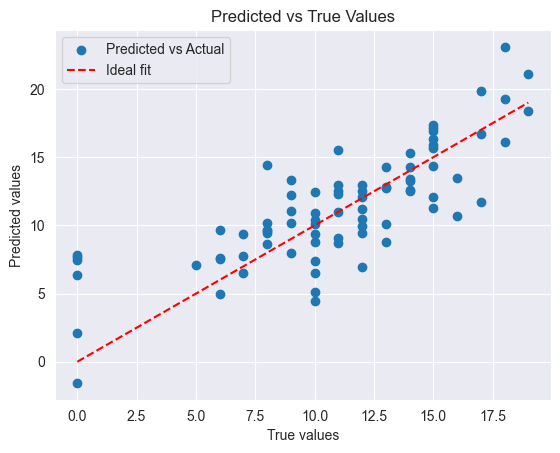

Degree 4 MSE: 8.541929711628722 R2: 0.5865193045083854


In [6]:
# Predict G3 but remove correlated inputs
_, _, X, y, _, _ = load_math_G3()
folds = 4
degrees = range(1, 5)
for degree in degrees:
    mse, r2, model = polynomial_regression(degree, X, y, folds)
    print("Degree", degree, "MSE:", mse, "R2:", r2)

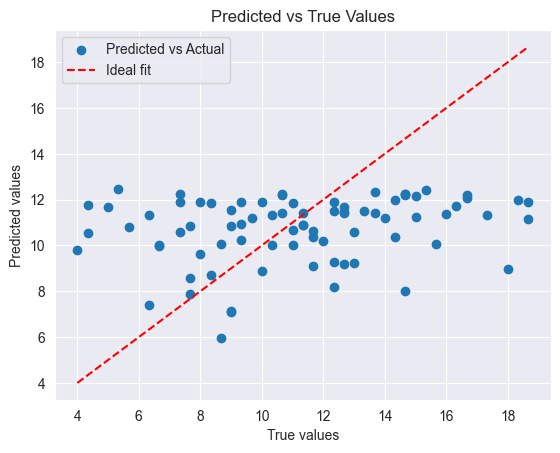

Degree 1 MSE: 12.88712695483622 R2: 0.01136405849176958


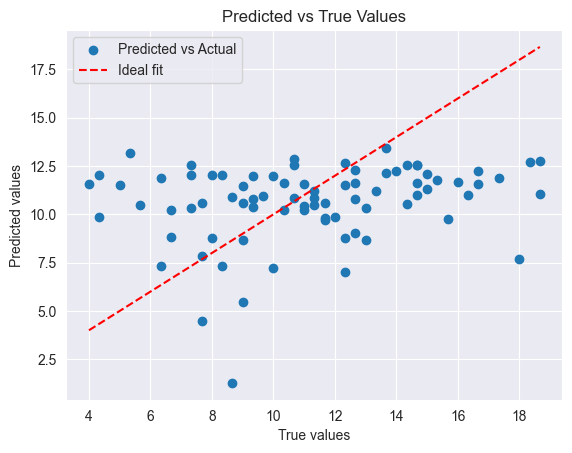

Degree 2 MSE: 14.115252700973196 R2: -0.08285160785323997


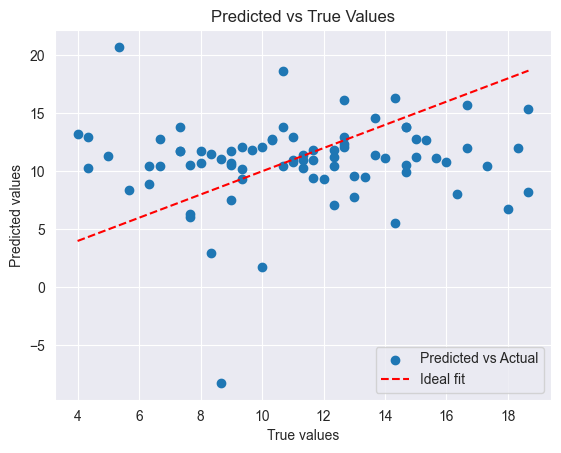

Degree 3 MSE: 24.189527898913973 R2: -0.8556996274493791


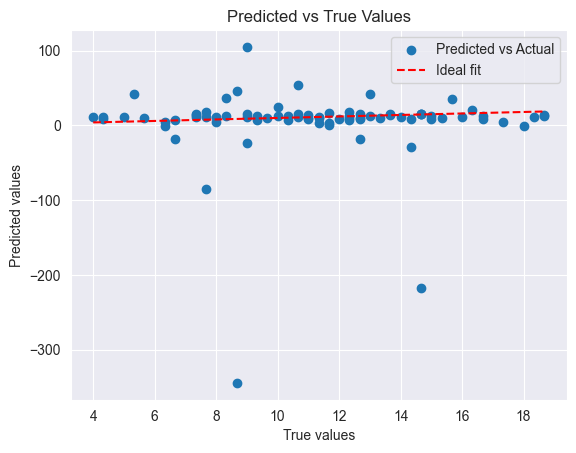

Degree 4 MSE: 2627.0830727261837 R2: -200.53667734687056


In [7]:
# Simple data model for web hosting (G_avg)
_, _, _, _, X, y = load_math_G_avg()
folds = 4
degrees = range(1, 5)
for degree in degrees:
    mse, r2, model = polynomial_regression(degree, X, y, folds)
    print("Degree", degree, "MSE:", mse, "R2:", r2)

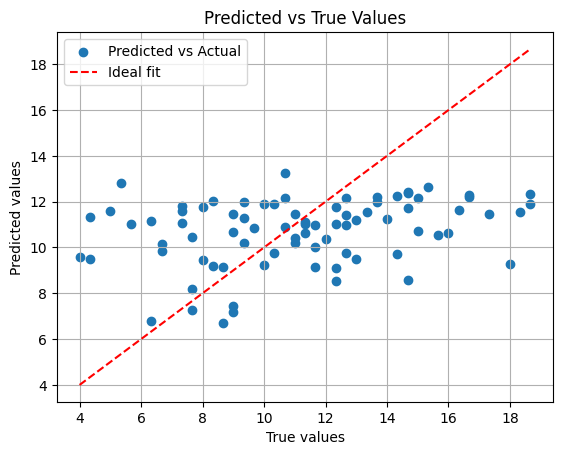

Degree 1 MSE: 12.224180624487289 R2: 0.06222198607880103


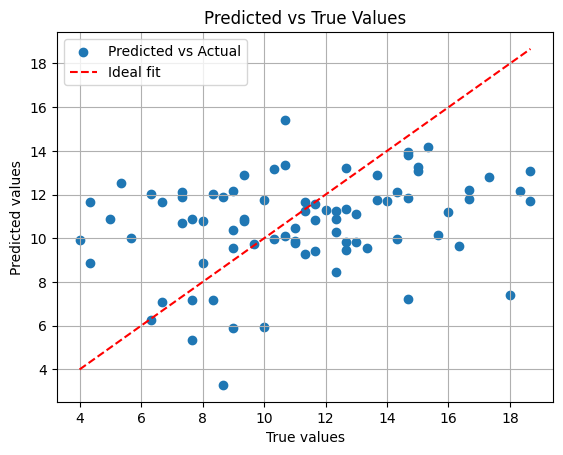

Degree 2 MSE: 13.56226318471415 R2: -0.04042901723495018


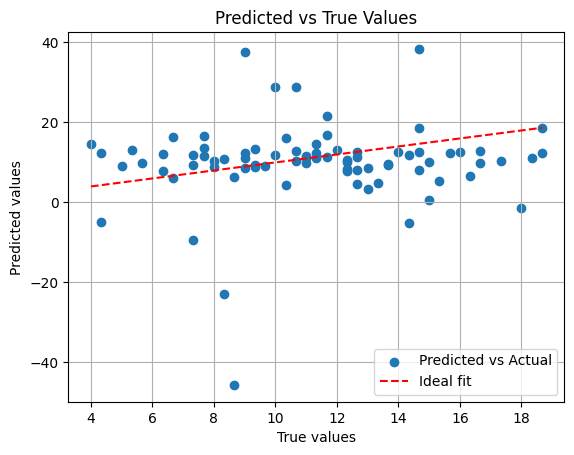

Degree 3 MSE: 112.79194295608886 R2: -7.652833879089592


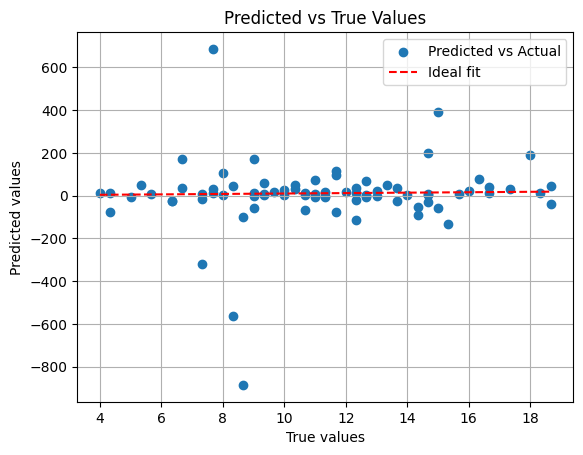

Degree 4 MSE: 26399.750452678207 R2: -2024.2568501756916


In [4]:
# BEST FOR WEBSITE

import pandas as pd

full_dataset = pd.read_csv("Math-Students.csv", sep=",")

# Change output label to average of grades
grades = ['G1', 'G2', 'G3']
full_dataset['G_avg'] = full_dataset[grades].mean(axis=1)
full_dataset = full_dataset.drop(columns=grades)

new_features = ['failures', 'absences', 'goout', 'age', 'health', 'freetime', 'studytime', 'Medu']
new_dataset = full_dataset[new_features + ['G_avg']]
X = new_dataset.drop("G_avg", axis=1)
y = new_dataset["G_avg"]
X = pd.get_dummies(X, drop_first=True)  # one-hot encode categorical features

folds = 4
degrees = range(1, 5)
for degree in degrees:
    mse, r2, model = polynomial_regression(degree, X, y, folds)
    print("Degree", degree, "MSE:", mse, "R2:", r2)

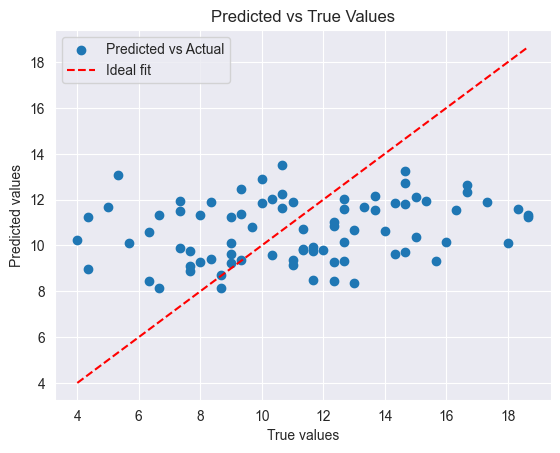

Degree 1 MSE: 12.78347819304905 R2: 0.019315473229494784


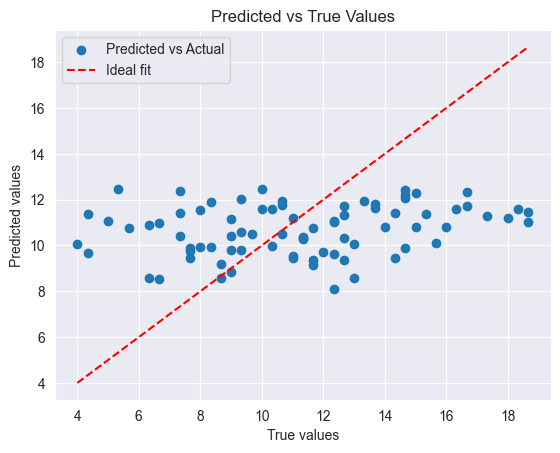

Degree 2 MSE: 12.500179084203037 R2: 0.04104876430235993


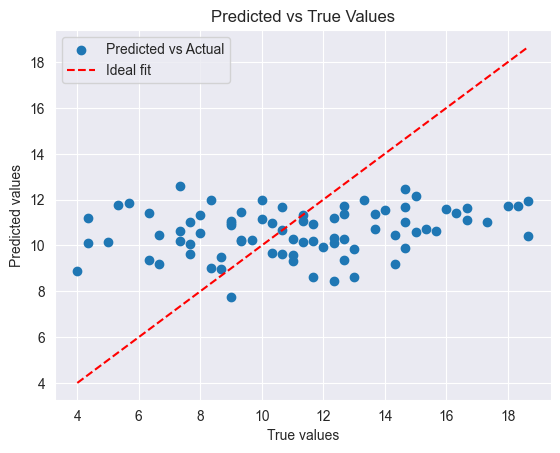

Degree 3 MSE: 12.664578056577643 R2: 0.02843689717276965


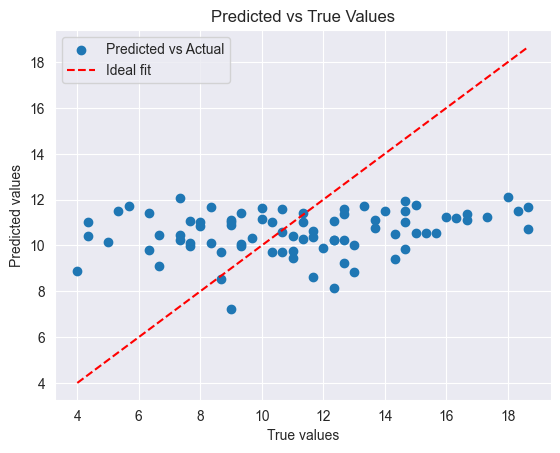

Degree 4 MSE: 12.738854040711553 R2: 0.02273881506625941


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def polynomial_regression(degree, X, y, folds, test_size=0.2):
    kf = KFold(folds)

    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(X)

    total_errors = []
    models = []
    current_fold = 0
    for train_index, test_index in kf.split(X_poly):
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        average_prediction = np.mean(y_pred)
        variance = np.mean((average_prediction - y_pred)**2)
        bias2 = np.mean((average_prediction - y_test)**2)
        total_error = variance + bias2

        # Append results to lists
        total_errors.append(total_error)
        models.append(model)

        current_fold += 1

    # choose best model
    min_error_index = np.argmin(total_errors)
    best_model = models[min_error_index]

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size, random_state=42)

    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    plt.scatter(y_test, y_pred, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal fit')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('Predicted vs True Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, best_model

X, y, _, _, _, _ = load_math_G_avg()
folds = 4
degrees = range(1, 5)
for degree in degrees:
    mse, r2, model = polynomial_regression(degree, X, y, folds)
    print("Degree", degree, "MSE:", mse, "R2:", r2)